# Classificação de animais

### Analise descritiva

Este projeto utiliza uma base de dados de imagens, contendo 28.266 imagens de animais pertencentes a 10 categorias: cachorro, gato, cavalo, aranha, borboleta, galinha, ovelha, vaca, esquilo e elefante.

O objetivo do projeto é comparar a eficiencia de diferentes classificadores ao predizer o animal presente na imagem.

#### Fonte dos dados:

Kaggle: https://www.kaggle.com/alessiocorrado99/animals10

#### Caracteristicas gerais:

* **Numero de registros:** 28266

* **Quantidade de variaveis:** 4

* **Dicionario de dados:**
    * **ID:** Id da imagem
    * **LABEL:** Categoria da imagem
    * **FILE:** Nome do arquivo da imagem
    * **IMG:** Imagem em RGB
   
* **Quantidade de valores ausentes por variavel:**
    * **ID:** N/A
    * **LABEL:** N/A
    * **FILE:** N/A
    * **IMG:** N/A
    
    
#### Analise descritiva das variaveis:

* **Dominio**:
    * **ID:** \[1 - 28266\]
    * **LABEL:** \[dog, cat, horse, spider, butterfly, chicken, sheep, cow, squirrel, elephant\]
* **Medidas de tendencia:**
    * **Media:** 2826.6 (media da quantidade de imagens em cada grupo)
    * **Mediana:** 2251.5 (mediana da quantidade de imagens em cada grupo)
    * **Moda:** 'spider' (grupo com maior quantidade de imagens)
* **Medidas de dispercao:** 
    * **Desvio Padrao:** 1231.845 (desvio padrao da quantidade de imagens em cada grupo)

## 1. Bibliotecas
Primeiramente carregamos todas as bibliotecas que serao utilizadas no projeto para manipulação de dados, aprendizado de maquina, multi-processamento e formatação.

In [1]:
# Libraries for data manipulation
import os
import time
import numpy as np
import pandas as pd
from scipy import stats

# Libraries for machine learning
from sklearn import tree
from skimage.io import imread
from skimage.feature import hog
from sklearn import preprocessing
from skimage.transform import rescale, resize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn import svm
import skimage
import cv2

# Libraries for multi-processing
import multiprocessing as mp

# Libraries for display formatting
import pydotplus
from graphviz import Source
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import clear_output, display
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Os marcadores **%matplotlib** e **%%javascript** definem apenas opções de visualização de output do jupyter-notebook.

## 2. Funções

### 2.1. Funções paralelas
Nesta parte carregamos as funções que serão chamadas paralelamente.

In [3]:
def load_image(i,dir,img):
        return [i,dir,img,imread("animals/{}/{}".format(dir,img))]
    
def load_hog(img,opt):
    return hog(img,orientations=opt['orientations'],
          pixels_per_cell=opt['pixels_per_cell'],
          cells_per_block=opt['cells_per_block'],
          visualise=opt['visualise'],
          block_norm=opt['block_norm'])
    
def make_square(im, size):
    border_v = 0
    border_h = 0
    if 1 >= (im.shape[0]/im.shape[1]):
        border_v = int(((im.shape[1])-im.shape[0])/2)
    else:
        border_h = int(((im.shape[0])-im.shape[1])/2)
    img = cv2.copyMakeBorder(im, border_v, border_v, border_h, border_h, cv2.BORDER_CONSTANT, 0)
    img = cv2.resize(img, (size, size))
    return img

pool = mp.Pool(processes=mp.cpu_count())

### 2.2. Funções comuns
Nesta parte carregamos as funções que serão chamadas normalmente pelo projeto.

In [4]:
def load_images():
    labels = np.array(os.listdir("animals"))
    results = []
    images = []
    meta = []
    
    i = 0
    for dir in labels:
        a = 0
        files = os.listdir("animals/"+dir)
        for img in files:
            if isinstance(img,str):
                i = i + 1
                a = a + 1
                results = results + [pool.apply_async(load_image, [i,dir,img])]
        meta = meta + [[dir, a]]
    
    images = [r.get() for r in results]
    return labels, pd.DataFrame(images, columns=['ID','LABEL','FILE','IMG']), pd.DataFrame(meta, columns=['LABEL','AMOUNT'])

def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5

    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]

    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'

    xtemp = np.arange(len(unique))

    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique)
    plt.xlabel('animal type')
    plt.ylabel(ylabel_text)
    
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()

    np.fill_diagonal(cmx_zero_diag, 0)

    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(10)) for a in ax]
    [a.set_yticks(range(10)) for a in ax]

    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')

    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    fig.colorbar(im3, ax=ax[2])
    fig.tight_layout()

## 3. Carregamento de imagens
Carrega imagens para analise.

In [5]:
labels, imgs, meta = load_images()
print(meta)

       LABEL  AMOUNT
0     spider    5133
1      sheep    1942
2   elephant    1483
3        dog    4908
4   squirrel    2013
5        cow    2039
6      horse    2672
7        cat    1941
8    chicken    3671
9  butterfly    2464


## 4. Medidas de tendencia central
Adquire valores de media, mediana, moda e desvio padrão.

In [6]:
amounts = meta.AMOUNT.values
imgs_labels = imgs.LABEL.values
print('Mean: '+str(np.mean(amounts))+'    Median:'+str(np.median(amounts))+'    Modal:'+str(stats.mode(imgs_labels, axis=None).mode)+'    STD:'+str(np.std(amounts)))

Mean: 2826.6    Median:2251.5    Modal:['spider']    STD:1231.8450551916014


## 5. Pré-processamento
Nesta parte faremos o pré-processamento dos dados.

### 5.1. Visualização
Nesta parte exibimos uma imagem de cada categoria para visualização.

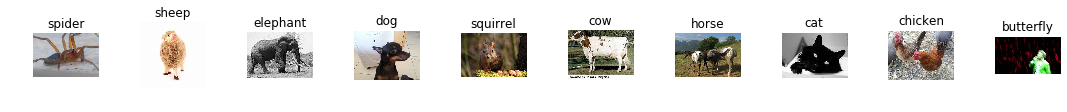

In [7]:
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()

# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    ax.imshow(imgs[imgs.LABEL == label].iloc[-1].IMG)
    ax.axis('off')
    ax.set_title(label)

### 5.2. Treino e teste
Nesta parte separamos os dados para treino e para teste.

In [8]:
X = np.array(imgs.IMG.values)
y = np.array(imgs.LABEL.values)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=42,
)

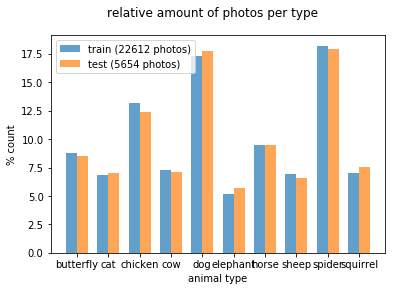

In [9]:
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)),
    'test ({0} photos)'.format(len(y_test))
]);

### 5.3. Histograma de Gradientes (HoG) e Maquinas de Vetores de Suporte (SVM)
Uma forma classica de se reconhecer objetos é adquirindo-se o Histograma de Gradientes da imagem e em seguida aplicar um classificador SVM a esse histograma.

Para calcular um HoG uma imagem é dividida em blocos, para cada bloco é calculado uma magnitude para o gradiente em um certo numero dado de direções.

Um classificador SVM speranda um plano a partir de uma serie de vetores e cada parte do plano representa um classe.

number of pixels:  67500
number of hog features:  21546


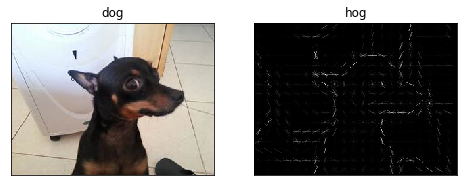

In [10]:
dog = imgs[imgs.LABEL == 'dog'].iloc[-1].IMG
# calculate the hog and return a visual representation.
dog_hog, dog_hog_img = hog(
    skimage.color.rgb2gray(dog), pixels_per_cell=(14, 14),
    cells_per_block=(3,3),
    orientations=9,
    visualise=True,
    block_norm='L2-Hys')

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    for a in ax]

print('number of pixels: ', dog.shape[0] * dog.shape[1])
print('number of hog features: ', dog_hog.shape[0])

ax[0].imshow(dog, cmap='gray')
ax[0].set_title('dog')
ax[1].imshow(dog_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

### 5.4. Transformadores
Descobrimos que para criar o HoG da imagem precisamos primeiramente converter todas as imagens para tons de cinza e garantir que todos as dimensoes são iguais, em seguida consiguimos gerar o HoG.

Como precisamos fazer isso para todas as imagens, foram criados "Transformadores" que realizam essas operações para todos os elementos do array.

In [11]:
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """returns itself"""
        return self

    def transform(self, X, y=None):
        results = []
        for img in X:
            results = results + [pool.apply_async(skimage.color.rgb2gray, [img])]     
            
        rr = []
        for r in results:
            rr = rr + [r.get()]
        
        return np.array(rr)

class SquareTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of grayscale images to same size square
    """

    def __init__(self, y=None, size=256):
        self.y = y
        self.size = size

    def fit(self, X, y=None):
        """returns itself"""
        return self

    def transform(self, X, y=None):
        results = []
        for img in X:
            results = results + [pool.apply_async(make_square, [img, self.size])]     
            
        rr = []
        for r in results:
            rr = rr + [r.get()]
        
        return np.array(rr)

class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """

    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(14, 14),
                 cells_per_block=(3, 3), visualise=False, block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.visualise = visualise
        self.block_norm = block_norm

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        results = []
        for img in X:
            results = results + [pool.apply_async(load_hog, [img,{
                       'orientations':self.orientations,
                       'pixels_per_cell':self.pixels_per_cell,
                       'cells_per_block':self.cells_per_block,
                       'visualise':self.visualise,
                       'block_norm':self.block_norm}])]        
        rr = []
        for r in results:
            rr = rr + [r.get()]
        
        return np.array(rr)

### 5.5. Preparo
Nesta parte preparamos os dados de treino e teste para serem processados pelas funções de classificação utilizando os transformadores.

In [12]:
grayify = RGB2GrayTransformer()
squarify = SquareTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14),
    cells_per_block=(3,3),
    orientations=9,
    block_norm='L2-Hys'
)
scalify = StandardScaler()

In [13]:
X_train_gray = grayify.fit_transform(X_train)
print(X_train_gray.shape)

(22612,)


In [14]:
X_train_square = squarify.fit_transform(X_train_gray)
print(X_train_square.shape)

(22612, 256, 256)


In [15]:
X_train_hog = hogify.fit_transform(X_train_square)
print(X_train_hog.shape)

(22612, 20736)


In [16]:
X_train_prepared = scalify.fit_transform(X_train_hog)
print(X_train_prepared.shape)

(22612, 20736)


In [17]:
X_test_gray = grayify.fit_transform(X_test)
print(X_test_gray.shape)

(5654,)


In [18]:
X_test_square = squarify.fit_transform(X_test_gray)
print(X_test_square.shape)

(5654, 256, 256)


In [19]:
X_test_hog = hogify.transform(X_test_square)
print(X_test_hog.shape)

(5654, 20736)


In [20]:
X_test_prepared = scalify.transform(X_test_hog)
print(X_test_prepared.shape)

(5654, 20736)


## 6. Arvore de Decisão
Nesta parte criamos uma arvore de decisão apenas para os 1000 primeiros elementos, o processo estava demorando muito para todas as 28266 imagens. Acredito que neste tipo de projeto a arvore de decisão não apresente tanto valor devido a dificuldade de se extrair qualquer informacao dela causada pela quantidade de elementos da arvore.

In [21]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_prepared[:1000], y_train[:1000])

In [22]:
dot_data = tree.export_graphviz(clf, out_file=None,class_names=labels,filled=True, rounded=True, special_characters=True)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"10,10!"')

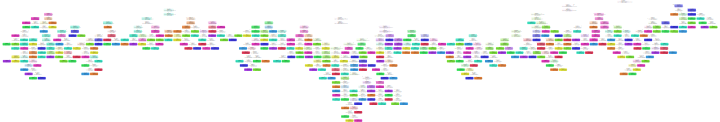

In [23]:
Source(pydot_graph.to_string())

## 7. Classificação

### 7.1. K-N-N
Nesta parte do projeto utilizamos o classificador K-N-N com 10 vizinhos para tentar classificar as imagens e demonstramos sua eficiencia.

In [24]:
knn_clf = KNeighborsClassifier(n_jobs=mp.cpu_count(), n_neighbors=10)
knn_clf.fit(X_train_prepared, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=32, n_neighbors=10, p=2,
           weights='uniform')

In [25]:
y_pred = knn_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Accuracy: ', 100*np.sum(y_pred == y_test)/len(y_test))

[False False False False False False False False False False  True False
 False False False False  True False False False False False  True False
 False]

Accuracy:  31.72974885037142


In [26]:
print('K-N-N Confusion Matrix:')
knn_cmx = confusion_matrix(y_test, y_pred)
print(knn_cmx)

K-N-N Confusion Matrix:
[[ 54   3  88   8  26   3   0  50 247   3]
 [  2  35  67   6  32  11   1  54 185   3]
 [  5   6 372   9  44   4   2  69 180   9]
 [  2   1  80  69  31   8   1 141  62   5]
 [  8  19 200  23 197  14  11 183 332  15]
 [  0   4  43  19  23  44   0 109  76   3]
 [  0   7  96  29  74  16  80 116 117   2]
 [  0   6  59  14  20   5   0 190  77   2]
 [ 15  10 120  13  40   8   2  74 730   2]
 [  1   8 104   6  37   5   0  65 180  23]]


K-N-N Confusion Matrix:

 ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


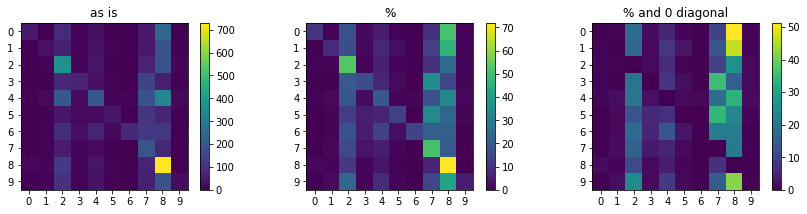

In [27]:
print('K-N-N Confusion Matrix:')

# the types appear in this order
print('\n', sorted(np.unique(y_test)))

plot_confusion_matrix(knn_cmx)

### 7.2. SGD
Nesta parte do projeto utilizamos o classificador SGD do tipo SVM para tentar classificar as imagens e demonstramos sua eficiencia.

In [28]:
sgd_clf = SGDClassifier(n_jobs=mp.cpu_count())
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=32, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [29]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Accuracy: ', 100*np.sum(y_pred == y_test)/len(y_test))

[ True False  True  True False  True False  True False False  True  True
 False False False  True  True  True False False False False False False
 False]

Accuracy:  46.46268128758401


In [30]:
print('SGD Confusion Matrix:')
sgd_cmx = confusion_matrix(y_test, y_pred)
print(sgd_cmx)

SGD Confusion Matrix:
[[228  24  27   7  25   7  10   9 129  16]
 [ 20 150  23   7  57  12  20  12  75  20]
 [ 19  37 402  19  65  10  25  26  56  41]
 [  9   7  31 162  46  38  46  39  14   8]
 [ 25  63 146  45 403  49  97  46  80  48]
 [  7   4  10  21  36 126  49  33  15  20]
 [  4  11  24  43  85  24 305  11  26   4]
 [  4  11  36  52  34  29  27 133  24  23]
 [ 80  55  83  17  62  14  29  34 584  56]
 [ 12  32  68  11  52  13  13  26  68 134]]


SGD Confusion Matrix:

 ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


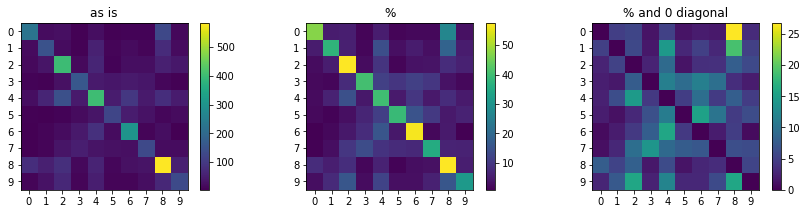

In [31]:
print('SGD Confusion Matrix:')

# the types appear in this order
print('\n', sorted(np.unique(y_test)))

plot_confusion_matrix(sgd_cmx)

K-N-N Confusion Matrix:

 ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


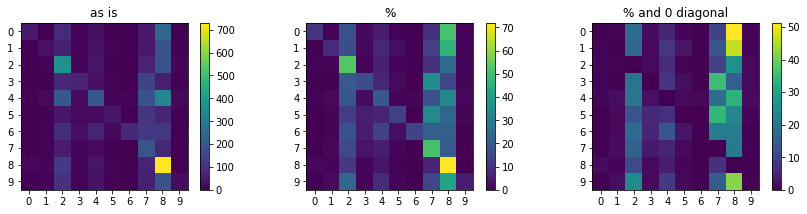

In [32]:
print('K-N-N Confusion Matrix:')

# the types appear in this order
print('\n', sorted(np.unique(y_test)))

plot_confusion_matrix(knn_cmx)

## 8. Conclusão
De acordo com os resultados apresentados, concluimos que o algoritimo K-N-N não é a melhor opção para esse tipo de analise e que os classificadores SVM são os recomendados para este tipo de projeto, encontramos um aumento em acuracia de 15% quando utilizando o classificador SVM. Nenhum dos classificadores utilizados na pesquisa atingiu minhas espectativas, acredito que o melhor classificador para este tipo de analise seria o SCV entretanto devido a recursos limitados e ao tempo de execução deste algoritmo (que é de ordem quadratica) não houve possibilidade de testar este algoritmo.

A acuracia baixa dos classificadores utilizados pode ser devida a qualidade do banco de imagens utilizado, acredito que o classificador SGD pode trazer resultados muito melhores para outros tipos de imagens ou para bancos maiores com maior qualidade de imagem, consequentemente com maior quantidade de dados sobre o histograma de gradiente das imagens.